In [1]:
import fitsio as fio
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib as matplotlib

In [2]:
cent = fio.FITS('/lsst/troxel/y1a1/lgt20_central_p80_fmasked.fits')[-1] # Central galaxy catalog (with shapes)
sat = fio.FITS('/lsst/troxel/y1a1/lgt20_satellite_p80_fmasked.fits')[-1] # Satellite p_mem >= 0.8 catalog

In [3]:
sat_id_unq, counts = np.unique(sat['MEM_MATCH_ID'].read(), return_counts=True)
clus_n = len(sat_id_unq)
sat_max = np.amax(counts)

In [4]:
len(sat.read())

87746

In [5]:
# Create 2D array for specified property of all satellite galaxies
def sat_prop(prop):
    sat_prop_full = sat[prop].read()
    new_array = np.zeros((clus_n,sat_max))
    k = 0
    for i in range(clus_n):
        new_array[i, 0:counts[i]] = sat_prop_full[k:k+counts[i]]
        new_array[i, counts[i]:] = np.nan
        k = k + counts[i]
    
    return new_array

In [6]:
# Calculate satellite angular position for all clusters
def sat_ang_pos():
    sat_ra = np.radians(sat_prop('RA'))
    sat_dec = np.radians(sat_prop('DEC'))
    cent_ra = np.radians(cent['RA'].read().reshape((clus_n,-1)))
    cent_dec = np.radians(cent['DEC'].read().reshape((clus_n,-1)))
    x = np.sin(sat_dec) * np.cos(cent_dec) - np.cos(sat_dec) * np.sin(cent_dec) * np.cos(sat_ra-cent_ra)
    y = np.sin(sat_ra-cent_ra) * np.cos(sat_dec)
    theta = np.arctan2(y, x)
    
    return theta

In [7]:
# Calculate position angle
def pos_ang(e1, e2):
    alpha = np.arctan2(-e2, -e1) / 2
    
    return alpha

In [8]:
# Calculate central galaxy alignment angle for all clusters
def cent_gal_ang():
    sat_ang = sat_ang_pos()
    cent_ang = pos_ang(cent['e1'].read(), cent['e2'].read()).reshape((clus_n,-1))
    delta = sat_ang - cent_ang
    delta = np.arcsin(np.abs(np.sin(delta)))
    delta = np.degrees(delta)
    
    return delta

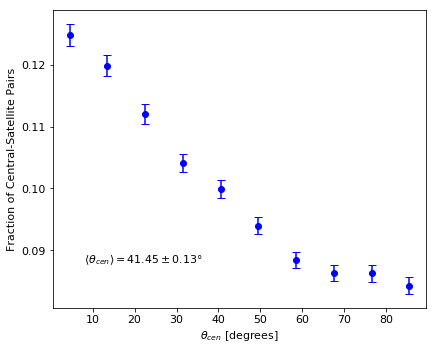

In [9]:
# Flatten central galaxy alignment angle array and plot histogram (with standard error of the mean)
cent_align = cent_gal_ang()
n_s = []
n_mean = []
for i in range(clus_n):
    samp = np.delete(cent_align, i, axis=0)
    mask_ = ~np.isnan(samp)
    samp = samp[mask_]
    n_, bins_ = np.histogram(samp, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
    n_s.append(n_)
    n_mean.append(np.mean(samp))
n_s = np.array(n_s)
n_mean = np.array(n_mean)
sigma = np.sqrt((clus_n-1)/clus_n*np.sum((n_s-np.mean(n_s, axis=0))**2, axis=0))
mean_sigma = np.sqrt((clus_n-1)/clus_n*np.sum((n_mean-np.mean(n_mean))**2))
mask = ~np.isnan(cent_align)
cent_align = cent_align[mask]
n, bins = np.histogram(cent_align, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
# k = 0
# new_array = np.zeros(10)
# for i in range(10):
#     bin_i = cent_align[k:k+n[i]]
#     std_i = np.std(bin_i)
#     sem_i = std_i/np.sqrt(n[i])
#     new_array[i] = sem_i
#     k = k + n[i]
# n_s=[]
# n_mean = []
# for i in range(5000):
#     rand = np.random.choice(cent_align, len(cent_align), replace=True)
#     n_, bins_ = np.histogram(rand, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
#     n_s.append(n_)
#     n_mean.append(np.mean(rand))
# n_s=np.array(n_s)
# n_mean = np.array(n_mean)
# sigma = np.sqrt((np.sum((n_s-np.mean(n_s,axis=0))**2,axis=0))/5000.)
# mean_sigma = np.sqrt((np.sum((n_mean-np.mean(n_mean))**2))/5000.)
# n_s = []
# n_mean = []
# N = len(cent_align)
# for i in range(N):
#     samp = np.delete(cent_align, i)
#     n_, bins_ = np.histogram(samp, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
#     n_s.append(n_)
#     n_mean.append(np.mean(samp))
# n_s = np.array(n_s)
# n_mean = np.array(n_mean)
# sigma = np.sqrt((N-1)/N*np.sum((n_s-np.mean(n_s, axis=0))**2, axis=0))
# mean_sigma = np.sqrt((N-1)/N*np.sum((n_mean-np.mean(n_mean))**2))
theta = r'$\theta_{cen}$'
matplotlib.rcParams.update({'font.size': 11}) # before plotting coode
plt.figure(figsize=(6.2,5))
plt.errorbar(bins[0:10]+4.5, n/len(sat['ID'].read()), yerr=sigma/len(sat['ID'].read()), fmt='bo', capsize=4)
plt.xlabel(r'$\theta_{cen}$ [degrees]')
plt.ylabel('Fraction of Central-Satellite Pairs')
# plt.legend()
plt.text(8, 0.088, fr'$\langle${theta}$\rangle = {np.mean(cent_align):.2f} \pm {mean_sigma:.2f} \degree$')
plt.tight_layout()
plt.savefig('/lsst/troxel/y1a1/plots/theta_cen.pdf', bbox_inches='tight')

In [10]:
np.mean(cent_align)

41.44661998304128

In [11]:
np.sum(counts)

87746